In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 29s 378ms/step - loss: 0.1935 - root_mean_squared_error: 0.4399 - val_loss: 0.0983 - val_root_mean_squared_error: 0.3136
Epoch 2/50
53/53 [==============================] - 16s 311ms/step - loss: 0.0587 - root_mean_squared_error: 0.2422 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2178
Epoch 3/50
53/53 [==============================] - 16s 301ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2097
Epoch 4/50
53/53 [==============================] - 18s 344ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 5/50
53/53 [==============================] - 17s 327ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1795
Epoch 6/50
53/53 [==============================] - 20s 391ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0224 

53/53 [==============================] - 3s 48ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656
Epoch 32/50
53/53 [==============================] - 24s 452ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 33/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 34/50
53/53 [==============================] - 23s 442ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 35/50
53/53 [==============================] - 21s 396ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630
Epoch 36/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0045 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.539053841431935 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

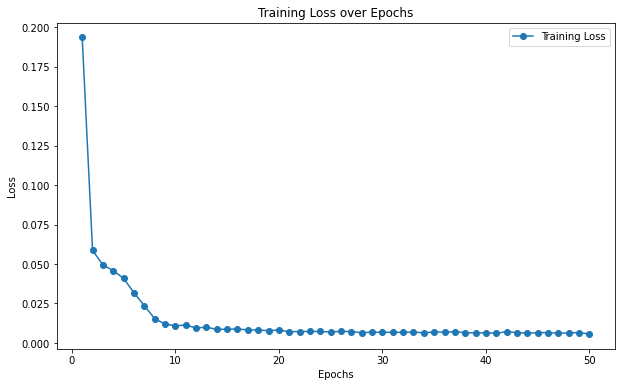

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

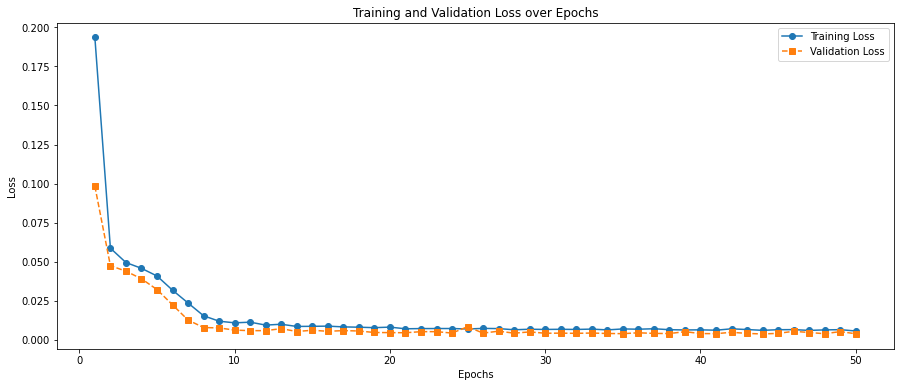

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 19ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06515848127680686
MAE : 0.05143488447268281


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.777446e+06,1960480.542
1,1.460742e+06,1264318.504
2,9.095569e+05,863206.294
3,4.178592e+05,635624.004
4,3.306198e+05,460009.672
5,4.582180e+05,610848.036
6,7.510999e+05,819257.445
7,1.098244e+06,1129627.707
8,1.410102e+06,1463383.236
9,1.665795e+06,1614536.727


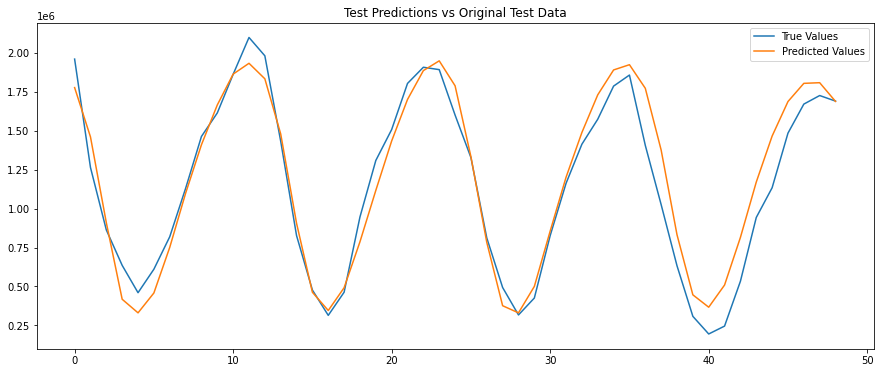

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 19ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

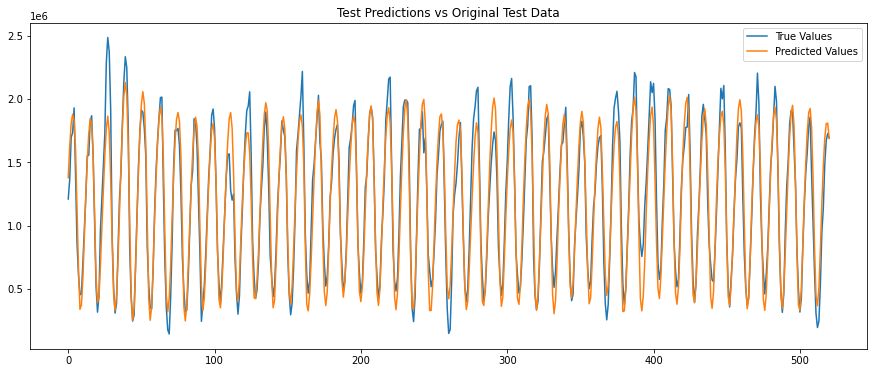

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()